# Get stationary time series 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot, norm
from random import seed
import utils
from cnn_graph.lib import graph

In [2]:
# Load data
dist_geo = pd.read_csv("data/distance_toulouse.csv",header=0,index_col=0)
X_hour = pd.read_csv("data/X_hour_toulouse.csv",header=0,index_col=0)
T_1, N = X_hour.shape
T_0 = int(X_hour.shape[0]*0.85)
T_tv = int(T_0*0.9)

## Weekly profile !only use the training set to get the profile!
X_train = X_hour.iloc[:T_tv,].copy()
index = np.tile(np.arange(1,24*7+1), np.int(X_hour.shape[0]/24/7)+1)[:X_hour.shape[0]] - 1
X_train['index'] = index[:T_tv]
wk_pf = X_train.groupby('index').mean()
X_train = X_train.drop(columns = "index")

X_hour, wk_pf = [np.float32(x) for x in [X_hour, wk_pf]]
X_hour_detrend = np.copy(X_hour) - wk_pf[index,:]

## Scale, to make the regularization parameter lambda have the same influence on all var.
X_train = X_hour_detrend[:T_tv,]
sd = X_train.std(axis = 0)
X_hour_detrend_sc = np.multiply(X_hour_detrend , 1/sd)
X_train, X_val, X_test = [X_hour_detrend_sc[:T_tv,], X_hour_detrend_sc[T_tv:T_0,], X_hour_detrend_sc[T_0:,]]

In [3]:
# Sampling size is given
P = int(0.1*N)
print(P)

18


# Algorithm 3: H = 0
## Sensor selection on training set, hyperparameters $\lambda$ tuning on validation set

In [4]:
# Input
## Build the graph
k = 20
dist, idx = graph.distance_sklearn_metrics(k = k, d = np.array(dist_geo))
A = graph.adjacency(dist, idx, k_self_tuning = 7).astype(np.float32)

## Construct the graph kernel
L = graph.laplacian(A, normalized=False)
K = utils.k_G(L.todense())

## Sample covariance
Sigma_hat = np.cov(X_train.T, bias=True)

In [5]:
eig_max = utils.power_iteration(np.array(K), 10)    
Pi = eig_max*np.linspace(0.001, 0.01, num = 5)
err = []
I_collection = []
for lda in Pi:
    I = utils.alg3(Sigma_hat, K, P, lda)
    Ic = list(set(range(N)) - set(I)) 
    # Reconstruction on validation set
    [X_I_hat0, err_mse0] = utils.ReKer0(I = I, K = K, X = X_val[:,Ic], Y = X_val[:,I], lda = lda)
    print("The reconstruction error on the validation set is: {}.".format(err_mse0))
    err.append(err_mse0)
    I_collection.append(I)

power iteration:
The tolerance 0.100 has been reached. The number of iterations is: 6
The reconstruction error on the validation set is: 21.10872984871906.
The reconstruction error on the validation set is: 21.49629518696182.
The reconstruction error on the validation set is: 21.120829793768646.
The reconstruction error on the validation set is: 21.225660644282144.
The reconstruction error on the validation set is: 23.47963305392647.


0.01148204056017501 [46, 0, 98, 6, 24, 139, 11, 114, 71, 8, 4, 140, 28, 116, 15, 137, 142, 25]


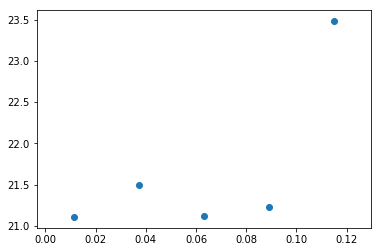

In [6]:
plt.rcParams["figure.figsize"] = (6,4)
plt.figure()
plt.scatter(Pi, err)

lda = Pi[np.argmin(err)]
I0 = I_collection[np.argmin(err)]
Ic0 = list(set(range(N)) - set(I0)) 
print(lda, I0)

## Reconstruction performance on test set

In [7]:
[X_I_hat0, err_mse0] = utils.ReKer0(I = I0, K = K, X = X_test[:,Ic0], Y = X_test[:,I0], lda = lda)
print("The reconstruction error on the test set is: {}.".format(err_mse0))

The reconstruction error on the test set is: 23.337122080658162.


## Comparison with baseline:  random sampling

In [8]:
err_mse_rand0 = np.zeros(100)
for i in range(100):
    I_rand = np.random.choice(N, P, replace=False)
    Ic_rand = list(set(range(N)) - set(I_rand)) 
    [_, err_mse_rand0[i]] = utils.ReKer0(I = I_rand, K = K, X = X_test[:,Ic_rand], Y = X_test[:,I_rand], lda = lda)
print("The average reconstruction error for random sampling set on the test set is: {}.".format(err_mse_rand0.mean()))

The average reconstruction error for random sampling set on the test set is: 28.351462674030568.


In [9]:
# Get the predictions of the original time series
X_I_hat0 = np.multiply(X_I_hat0, sd[I0]) # Multiply the std back
X_I_hat0 += wk_pf[index[T_0:],:][:,I0] # Add the trend back

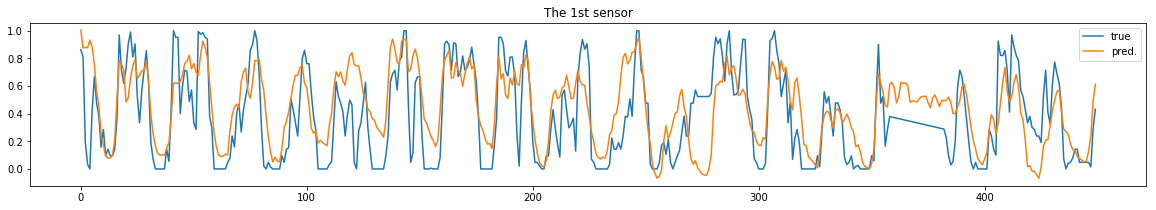

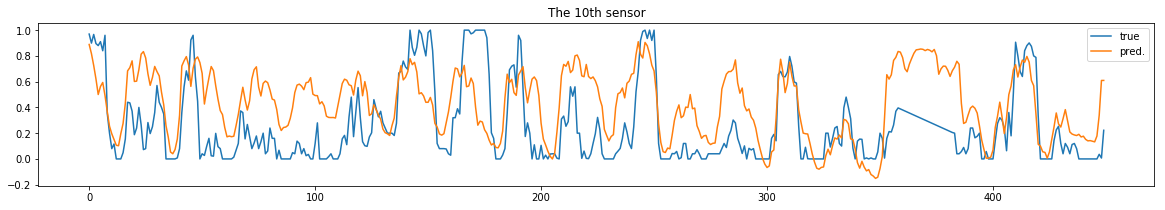

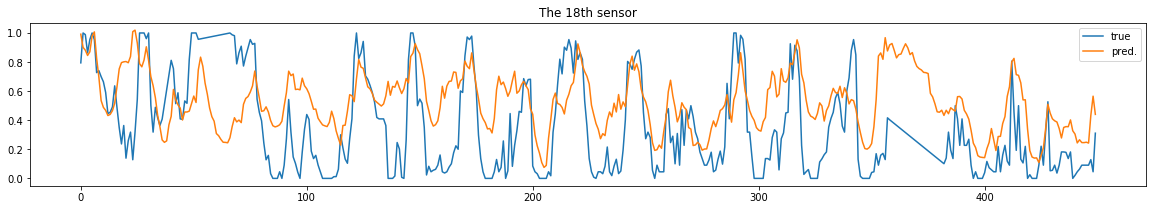

In [10]:
# Visualization
x = 450
plt.rcParams["figure.figsize"] = (20,3)
plt.figure()
plt.plot(X_hour[T_0:T_0+x,][:,I0][:,0], label = "true")
plt.plot(X_I_hat0[:x,0], label = "pred.")
plt.title("The 1st sensor")
plt.legend()
plt.figure()
plt.plot(X_hour[T_0:T_0+x,][:,I0][:,int(P/2)], label = "true")
plt.plot(X_I_hat0[:x,int(P/2)], label = "pred.")
plt.title("The {}th sensor".format(int(P/2)+1))
plt.legend()
plt.figure()
plt.plot(X_hour[T_0:T_0+x,][:,I0][:,P-1], label = "true")
plt.plot(X_I_hat0[:x,P-1], label = "pred.")
plt.title("The {}th sensor".format(P))
plt.legend()

# Algorithm 4: H > 0
## Sensor selection on training set, hyperparameters $H, \gamma, \lambda$ tuning on validation set

In [11]:
grid = []
err = []
I_collection = []
G_H = [1, 5, 10]

for H in G_H:
    gamma = -np.log(0.3)/H**2 # To make sure exponential decay do not cancel out the past
    print("H = {:}, Gamma = {:3.3f}".format(H, gamma))
    St1 = [(j,0) for j in np.arange(N)]
    St2 = []
    for l in -np.arange(H+1):
        St2 += [(j,l) for j in np.arange(N)]
    KH = utils.btoep(utils.k_GT(L.todense(), gamma, St1, St2))
    
    # Estimate the largest eigenvalue so as to set the grid for lambda
    eig_max = utils.power_iteration(KH, 10)    
    Pi = eig_max*np.linspace(0.001, 0.01, num = 5)
    
    AlphaH = multi_dot([X_train[H:,:].T, X_train[H:,:]])
    for l_col in np.arange(H)+1:
        AlphaH = np.append(AlphaH, multi_dot([X_train[H:,:].T, X_train[(H-l_col):(T_tv-l_col),:]]), axis = 1) 
    AlphaH /= T_tv
    AlphaH = utils.btoep(AlphaH)
    
    for lda in Pi:
        I = utils.alg4(Sigma_hat, KH, AlphaH, P, H, lda, inv_method = 'cg', tol = 0.001*KH.std())
        Ic = list(set(range(N)) - set(I)) 
        # Reconstruction on validation set
        X_val_H_Ic = X_val[H:,Ic]
        T = X_val.shape[0]
        for l in np.arange(H)+1:
            X_val_H_Ic = np.append(X_val_H_Ic, X_val[(H-l):(T-l),Ic], axis = 1)
        [X_I_hat_H, err_mse_H] = utils.ReKerH(I, H, KH, X_val_H_Ic, X_val[H:,I], lda = lda, inv_method = 'cg', tol = 0.001*KH.std())

        print("Lambda is: {: 3.3f}, the reconstruction error on validation set is: {: 3.3f}. \n".format(lda, err_mse_H))
        grid.append((H, lda, gamma))
        err.append(err_mse_H)
        I_collection.append(I)
        
(H, lda, gamma) = grid[np.argmin(err)]
I_H = I_collection[np.argmin(err)]
Ic_H = list(set(range(N)) - set(I_H)) 
print(H, lda, gamma)
print(I_H)

H = 1, Gamma = 1.204
power iteration:
The tolerance 0.100 has been reached. The number of iterations is: 8
The percentage done is: 0.00
The percentage done is: 0.22
The percentage done is: 0.44
The percentage done is: 0.61
The percentage done is: 0.83
Lambda is:  0.015, the reconstruction error on validation set is:  21.073. 

The percentage done is: 0.00
The percentage done is: 0.22
The percentage done is: 0.44
The percentage done is: 0.61
The percentage done is: 0.83
Lambda is:  0.048, the reconstruction error on validation set is:  21.480. 

The percentage done is: 0.00
The percentage done is: 0.22
The percentage done is: 0.44
The percentage done is: 0.61
The percentage done is: 0.83
Lambda is:  0.082, the reconstruction error on validation set is:  21.100. 

The percentage done is: 0.00
The percentage done is: 0.22
The percentage done is: 0.44
The percentage done is: 0.61
The percentage done is: 0.83
Lambda is:  0.116, the reconstruction error on validation set is:  21.209. 

The p

## Reconstruction performance on test set

In [12]:
St1 = [(j,0) for j in np.arange(N)]
St2 = []
for l in -np.arange(H+1):
    St2 += [(j,l) for j in np.arange(N)]
KH = utils.btoep(utils.k_GT(L.todense(), gamma, St1, St2))

X_test_H_Ic = X_test[H:,Ic_H]
T = X_test.shape[0]
for l in np.arange(H)+1:
    X_test_H_Ic = np.append(X_test_H_Ic, X_test[(H-l):(T-l),Ic_H], axis = 1)  
[X_I_hat_H, err_mse_H] = utils.ReKerH(I_H, H, KH, X_test_H_Ic, X_test[H:,I_H], lda=lda, inv_method = 'cg', tol = 0.001*KH.std())

print("The reconstruction error on the test set is: {}.".format(err_mse_H))

The reconstruction error on the test set is: 18.629921420200212.


In [13]:
# Get the predictions of the original time series
X_I_hat_H = np.multiply(X_I_hat_H, sd[I_H]) # Multiply the std back
X_I_hat_H += wk_pf[index[T_0+H:],:][:,I_H] # Add the trend back

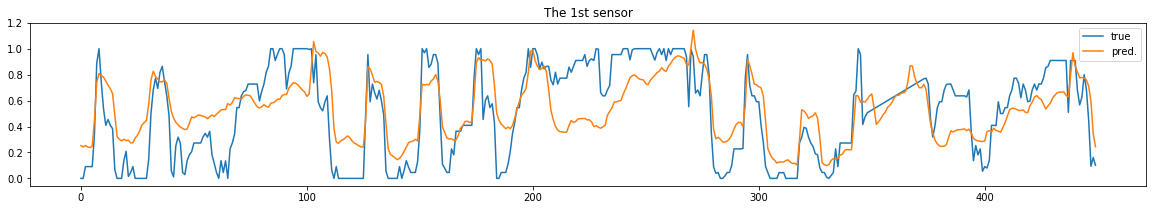

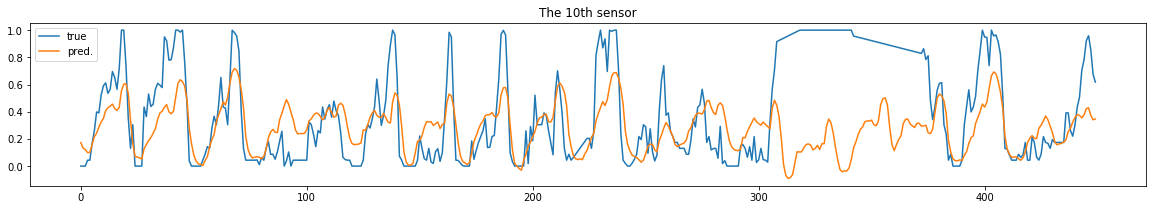

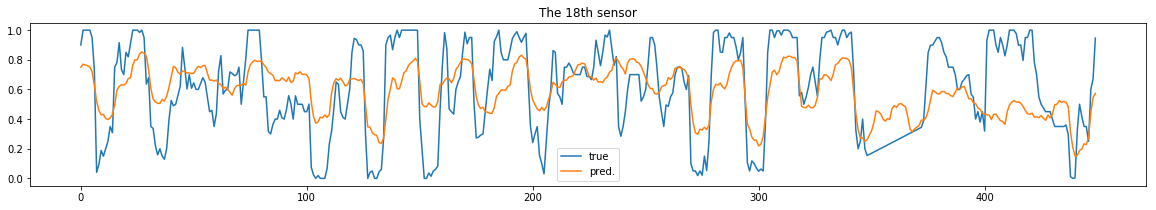

In [14]:
## Visualization
# Visualization
x = 450
plt.rcParams["figure.figsize"] = (20,3)
plt.figure()
plt.plot(X_hour[T_0+H:T_0+H+x,][:,I_H][:,0], label = "true")
plt.plot(X_I_hat_H[:x,0], label = "pred.")
plt.title("The 1st sensor")
plt.legend()
plt.figure()
plt.plot(X_hour[T_0+H:T_0+H+x,][:,I_H][:,int(P/2)], label = "true")
plt.plot(X_I_hat_H[:x,int(P/2)], label = "pred.")
plt.title("The {}th sensor".format(int(P/2)+1))
plt.legend()
plt.figure()
plt.plot(X_hour[T_0+H:T_0+H+x,][:,I_H][:,P-1], label = "true")
plt.plot(X_I_hat_H[:x,P-1], label = "pred.")
plt.title("The {}th sensor".format(P))
plt.legend()

## Comparison with baseline:  random sampling

In [15]:
err_mse_rand_H = np.zeros(100)
for i in range(100):
    I_rand = np.random.choice(N, P, replace=False)
    Ic_rand = list(set(range(N)) - set(I_rand))     
    X_test_H_Ic = X_test[H:,Ic_rand]
    T = X_test.shape[0]
    for l in np.arange(H)+1:
        X_test_H_Ic = np.append(X_test_H_Ic, X_test[(H-l):(T-l),Ic_rand], axis = 1)        
    [X_I_hat_H_rand, err_mse_rand_H[i]] = utils.ReKerH(I_rand, H, KH, X_test_H_Ic, X_test[H:,I_rand], lda = lda, inv_method = 'cg')
print("The average reconstruction error for random sampling set on the test set is: {}.".format(err_mse_rand_H.mean()))

The average reconstruction error for random sampling set on the test set is: 20.829886251128478.
